<a href="https://colab.research.google.com/github/BubuDavid/RRT-Bidirectional-Dijstrak/blob/main/4_1_RRT_Bidireccional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *Nota*: Si no puedes ver bien el contenido del archivo, te recomiendo que vayas al link del código original: https://colab.research.google.com/drive/1jXuMbBPjwM9eTBh87t0N0qBrgv9VZjbd?usp=sharing

# Proyecto de Investigación de Operaciones: Generacion de Ruta
Integrantes:
- David Pedroza Segoviano
- Fátima Abril Ibarra Marmolejo
- José Francisco Valdivia Cisneros
- Cesia Eunice Argüelles Espinoza

# 0. Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as PlotPolygon
from shapely.geometry import Polygon, Point, LineString
import time
from copy import copy

# 1. Objetos a utilzar
En este caso usaremos un objeto mapa y un objeto grafo. Esto para mantener una independencia entre el terreno en el que estamos y el objeto que estamos expandiendo.

## 1.1 Mapa
Este es el terreno en el que buscaremos la mejor ruta para ir de un punto inicial a uno final. Es generalizable lo que significa que podemos ponerle cualquier obstáculo y puntos incial y final que querramos.

In [ ]:
class Map:
    def __init__(self, initial_node = [0,0], end_node = [0,0], obstacles_x = [], obstacles_y = [], space_limits = [[0, 30], [0, 30]]):
        """
            Constructor de Mapa.
        """
        # Definimos los atributos iniciales
        self.obs_x = obstacles_x
        self.obs_y = obstacles_y
        self.initial_node = initial_node
        self.end_node = end_node
        self.space_limits = space_limits
        self.graph1 = None
        self.graph2 = None
        # Creamos los objetos obstáculos tanto para cálculos como para gráficos.
        self.generate_obstacles()

    def generate_obstacles(self):
        """
            Esta función crea todos los obstáculos tanto para cálculos (Polygon) como para graficar (Plot Polygon)
            está basado en las funciones que vimos en la clase de matlab.
        """
        # Define los estados iniciales de cada una de las listas
        self.obstacles = [] # Para cálculos de colisiones
        self.obstacles_for_plotting = [] # Para graficar en matplotlib de manera eficiente
        # Transforma de tipo matlab a Polygon de matplotlib y a Polygon de shapely
        for x_list, y_list in zip(self.obs_x, self.obs_y):
            coords = []
            for x, y in zip(x_list, y_list):
                coords.append((x, y))

            self.obstacles.append(Polygon(coords))
            self.obstacles_for_plotting.append(PlotPolygon(coords, edgecolor = 'black', facecolor = 'gray'))

    def show_graph(self, graph, ax, all_connections, s, color = 'green'):
        nodes_x, nodes_y = graph.nodes
        ax.scatter(nodes_x, nodes_y, c = color)
        # Grafica todas las conexiones (no recomendable) si así se desea
        # Esto aumenta mucho el tiempo de graficación, no recomiendo.
        if all_connections:
            for initial_node_index, connections in enumerate(graph.connections):
                for connection_index in connections:
                    x1 = nodes_x[initial_node_index]
                    x2 = nodes_x[connection_index]
                    y1 = nodes_y[initial_node_index]
                    y2 = nodes_y[connection_index]
                    ax.plot([x1, x2], [y1, y2], c = color, s = s)

        # Grafica las conexiones si es que se tiene el camino final
        best_path = graph.best_path
        if best_path:
            current_index = 0
            next_index = 1
            n = len(best_path)
            while next_index < n:
                current_node = best_path[current_index]
                next_node = best_path[next_index]
                x1 = graph.nodes[0][current_node]
                y1 = graph.nodes[1][current_node]
                x2 = graph.nodes[0][next_node]
                y2 = graph.nodes[1][next_node]

                ax.plot([x1, x2], [y1, y2], 'o-', c = 'r')

                current_index += 1
                next_index += 1

    def show(self, title = 'Mapa con obstáculos', all_connections = False, figsize = (7,7), s = 5):
        """
            Esta función grafica el mapa, tanto los obstáculos, el punto inicial y final y el grafo generado si es que lo hay.
            También grafica el camino óptimo si es que ya está calculado dentro del grafo.
        """
        # Define el tamaño de nuestra figura
        fig, ax = plt.subplots(figsize = figsize)
        
        # Grafica los obstáculos con ayuda de patch de matplotlib
        for obstacle in self.obstacles_for_plotting:
            obs_copy = copy(obstacle) # Esto se tiene que hacer por un bug que anda por ahí, no hace mucha diferencia
            ax.add_patch(obs_copy)

        # Grafica los nodos del grafo 1 si es que lo hay
        if self.graph1:
            self.show_graph(graph=self.graph1, ax=ax, all_connections=all_connections, color = 'blue', s = s)
        if self.graph2:
            self.show_graph(graph=self.graph2, ax=ax, all_connections=all_connections, color = 'orange', s = s)


        # Graficando los puntos inicial y final
        ax.scatter(*self.initial_node, c = 'blue')
        ax.scatter(*self.end_node, c = 'orange')


        
        # Límites y configuraciones finales
        ax.set_xlim(self.space_limits[0])
        ax.set_ylim(self.space_limits[1])
        ax.set_title(title)
        plt.show()

## 1.2 Grafo
Este es el grafo que vamos a expandir en nuestro terreno, es muy general por lo tanto no tiene restricciones atadas, de eso se encarga el Mapa y los algoritmos de búsqueda.

In [ ]:
class Graph:
    def __init__(self, space_limits = [[0, 30], [0, 30]],):
        """ Definición del grafo, simplemente hay que poner space_limits pero no es necesario, todo se crea en automático simplemente mandando a llamar el constructor.
        """
        # Aquí se guardan los nodos: Esto tiene la forma [[node0_x, node1_x,...], [node0_y, node1_y,...]]
        self.nodes = [[], []]
        # Aquí se guardan las conexiones que tienen los nodos: # Esto tiene la forma [[connected_node00_index, connected_node01_index,...], [connected_node10_inex, connected_node11_index,...]]
        self.connections = []
        # Aquí se guardan las distancias que hay entre los nodos y sus conecciones # Esto tiene la forma [[distance_between_0_and_connected_node00]]
        self.distances = []
        # Esto indicará que el grafo está completo
        self.complete = False
        # Esto indicará el path óptimo
        self.best_path = None

    def add_node(self, new_node_coords, connected_node_index = None):
        """ Función que nos añade un nodo y su conexión con algún otro nodo si es necesario.
            new_node (List[x,y]): Las coordenadas [x,y] en una lista del nuevo nodo
            nearest_node (int): El index del nodo más cercano al nuevo nodo
        """
        # Agregando un nodo y su index a la lista
        new_index = len(self.nodes[0])
        self.nodes[0].append(new_node_coords[0])
        self.nodes[1].append(new_node_coords[1])
        # Creando su arreglo de connexiones
        self.connections.append([])
        self.distances.append([])
        # Agregar su conexión con el el nodo indicado si es que lo hay
        if connected_node_index is not None:
            self.connections[connected_node_index].append(new_index)
            # Para agregar las distancias necesitamos el nodo y sus coordenadas
            x1 = self.nodes[0][connected_node_index]
            y1 = self.nodes[1][connected_node_index]
            # Calculamos la pseudo-distancia (sin la raíz cuadrada ya que es muy costosa y no hace mucha diferencia para lo que queremos hacer)
            x2, y2 = new_node_coords
            new_dist = (x1-x2)**2 + (y1-y2)**2
            self.distances[connected_node_index].append(new_dist)

        return new_index

    def get_nearest_index(self, point):
        """ 
            Regresa el id del nodo más cercano a un punto dado junto con la distancia a este.
            Es un algoritmo muy simple, lineal en tiempo respecto al número de nodos y constante en espacio.
        """
        min_dist = np.inf
        min_index = -1
        for index in range(len(self.nodes[0])):
            x1, y1 = point
            x2, y2 = self.nodes[0][index], self.nodes[1][index]
            current_dist = (x1-x2)**2 + (y1-y2)**2 # Usamos la pseudo-distancia porque aplicar la raíz cuadrada es muy costoso computacionalmente y no nos hace falta aquí.

            if current_dist < min_dist:
                min_dist = current_dist
                min_index = index

        return min_index, min_dist

# 2. Funciones de path planning y de búsqueda 

## 2.1 Funciones auxiliares al RRT

In [ ]:
def generate_random_point(space_limits):
    """
        Función para generar un punto aleatorio
    """
    [min_x, max_x], [min_y, max_y] = space_limits
    random_x = min_x + np.random.rand() * (max_x - min_x)
    random_y = min_y + np.random.rand() * (max_y - min_y)
    random_point = [random_x, random_y]

    return random_point

def is_in_Polygon(coords, polygons):
    """
        Función para saber si un punto está dentro de algún polígono en un conjunto de polígonos dado
    """
    point = Point(coords)
    for polygon in polygons:
        if point.within(polygon):
            return True

    return False

def intersects_with_polygon(coords1, coords2, polygons):
    """
        Función para detectar si una línea (conexión entre dos nodos en este caso) no atraviesa polígonos dados 
    """
    point1 = Point(coords1)
    point2 = Point(coords2)
    line = LineString([point1, point2])
    for polygon in polygons:
        if line.intersects(polygon):
            return True
    return False

def try_to_add_nodes(g, g2, random_point, search_radius):
    # Detectar cuál nodo del grafo1 está más cerca
        nearest_node_index, nearest_dist = g.get_nearest_index(random_point)
        nearest_dist = np.sqrt(nearest_dist)

        # Da el paso en dirección a este nodo aleatorio para el grafo1 
        nearest_coords = g.nodes[0][nearest_node_index], g.nodes[1][nearest_node_index]
        directional_vector = np.array(random_point) - np.array(nearest_coords)
        directional_vector_normalized = (directional_vector / nearest_dist) * min(search_radius, nearest_dist)

        # Crea el nodo en el punto requerido para el grafo 1
        new_coords = nearest_coords[0]+directional_vector_normalized[0], nearest_coords[1]+directional_vector_normalized[1]
        
        # Valida si este nodo no esta dentro de un obstaculo y que su conexión no atraviese paredes para el nodo 1
        if is_in_Polygon(new_coords, plane.obstacles) or intersects_with_polygon(nearest_coords, new_coords, plane.obstacles):
            return False

        # Agrega el punto al grafo con su respectiva conexión si es que se cumplen las condiciones para ambos grafos
        new_index1 = g.add_node(new_coords, nearest_node_index)

        # Checar si este nodo del grafo 1 y alguno de los nodos del grafo 2 se pueden interseccionar, en caso de que así sea, checar que su conexión no atraviese un obstáculo
        nearest_node2_for_node1_index, nearest_dist21 = g2.get_nearest_index(new_coords)
        nearest_node2_for_node1 = g2.nodes[0][nearest_node2_for_node1_index], g2.nodes[1][nearest_node2_for_node1_index]

        if nearest_dist21 <= search_radius ** 2 and not intersects_with_polygon(new_coords, nearest_node2_for_node1, plane.obstacles):
            g.add_node(nearest_node2_for_node1, new_index1)
            g.complete = True
            g2.add_node(new_coords, nearest_node2_for_node1_index)
            g2.complete = True

            return True

## 2.2 RRT Bidireccional
Este es el algoritmo clave que genera nodos para viajar del nodos inicial al nodo final.

In [ ]:
def RRT_bidirectional(g1, g2, plane, search_radius = 0.5, space_limits = [[0, 30], [0, 30]], iter_limit = 1000000, verbose = False, **kwargs):
    """
    Ejecuta un RRT bidireccional para dos grafos dado en un mapa de restricciones.
    g1 (Graph): Grafo1 a tratar para ejecutar el RRT
    g2 (Graph): Grafo2 para ejectuar el otro RRT
    plane (Map): Espacio de busqueda con restricciones
    search_radius (float): Tamaño del paso del algoritmo
    space_limits (List[[x1, x2], [y1, y2]]): Límites de búsqueda para x y y.
    iter_limit (int): Número de iteraciones máximas para el algoritmo 
    """
    # Loop para generar nodos (con un máximo de iter_limit iteraciones)
    for iter in range(iter_limit):
        add_node1 = True
        add_node2 = True
        # Generar punto aleatorio
        random_point = generate_random_point(space_limits)
        
        # Vamos a tratar de agregar los nodos a partir de este punto aleatorio con el algoritmo RRT en ambos grafos
        trying1 = try_to_add_nodes(g1, g2, random_point, search_radius)
        if g1.complete:
            break
        try_to_add_nodes(g2, g1, random_point, search_radius)
        if g2.complete:
            break

    if g1.complete and verbose:
        print("¡Sí llegamos 🥳!")
        print("Número de iteraciones:", iter + 1)
    else:
        if verbose:
            print("No llegamos 😢")

## 2.3 Algoritmo de Dijkstra
Este es el algoritmo que se usa una vez teniendo un grafo completo para encontrar el camino óptimo.

In [ ]:
def dijkstra_algorithm(nodes, node_weights, initial_node = 0, end_node = -1, verbose = False):
    if end_node == -1:
        end_node = len(nodes) - 1
    # Se define la lista de distancias más corta a los nodos
    dist = [-1 for i in range(len(nodes))]
    path = [-1 for i in range(len(nodes))]
    # Se define el nodo inicial a 0
    dist[initial_node] = 0
    # Se define el pivote inicial
    pivs = [[initial_node, 0]]
    # Inicio de algoritmo (Se parará hasta que la cola de prioridad se vacíe)
    while len(pivs) >= 1:
        # Se define una lista de pivotes nuevos que serán los nodos que estaremos checando
        new_pivots = []
        # Se recorre cada uno de las conexiones que el nodo actual tiene
        for index, node in enumerate(nodes[pivs[-1][0]]):
            # Se obtiene el valor del nodo para el siguiente pivote
            next_pivot = node
            # Se obtiene la suma actual para este camino
            next_suma = pivs[-1][1] + node_weights[pivs[-1][0]][index]
            
            # Checamos si nunca hemos visitado este nodo antes O si hemos llegado por un camino más corto, en este caso reemplazamos el valor de la distancia
            # y agregamos el "nuevo pivote" a nuestra lista de pivotes
            if dist[next_pivot] == -1 or dist[next_pivot] > next_suma:
                dist[next_pivot] = next_suma # Modificamos la distancia
                path[next_pivot] = pivs[-1][0]
                new_pivot = [next_pivot, next_suma]
                new_pivots.append(new_pivot) # Agregamos el nuevo pivote con la nueva suma

        # Checar si nuestra nueva lista de pivotes tiene algo extra. Si no, entonces este pivote ya no nos interesa y lo removemos con pop
        if not len(new_pivots):
            pivs.pop()
        else: # Si si nos sirve simplemente lo agregamos a los pivotes.
            pivs += new_pivots

    # Obtenemos el camino óptimo
    smallest_path = [end_node]
    current_node = path[end_node]
    while current_node != -1:
        smallest_path.append(current_node)
        current_node = path[current_node]

    smallest_path = smallest_path[::-1]

    if verbose:
        # Imprimir resultados
        for index, d in enumerate(dist):
            print(f"El camino más corto para llegar al nodo {index} es: {d}")

        print()
        # Backtracking de los paths
        print(f"El camino más corto para llegar al nodo {end_node} es:")

        for node in smallest_path:
            print(f"{node}, ", end = '')
    return smallest_path

## 2.4 Función para juntar todas estas funciones en una sola y hacer una búsqueda rápida, así se podrá medir el tiempo que tarda también.

In [ ]:
def search_path(plane, search_radius = 5, space_limits = [[0, 30], [0, 30]], title = 'Camino óptimo a partir del RRT Bidireccional', iter_limit = 1000000, show = False, verbose = False, **kwargs):
    """
        Función que toma un terreno (mapa) con puntos iniciales y finales y aplica RRT Bidireccional para obtener un camino de inicio a fin (No necesariamente es el óptimo).
        También toma el tiempo que tarda en ejecutar el código.
    """
    start_time = time.time()
    plane.graph1 = None
    plane.graph2 = None
    graph1 = Graph()
    graph2 = Graph()
    graph1.add_node(plane.initial_node)
    graph2.add_node(plane.end_node)
    RRT_bidirectional(graph1, graph2, plane, search_radius, space_limits, verbose = verbose)
    plane.graph1 = graph1
    plane.graph2 = graph2
    best_path1 = dijkstra_algorithm(graph1.connections, graph1.distances)
    best_path2 = dijkstra_algorithm(graph2.connections, graph2.distances)

    graph1.best_path = best_path1
    graph2.best_path = best_path2
    end_time = time.time()
    if show:
        plane.show(title = title, s = 0.1)

    if verbose:
        print('Se tardó:', end_time - start_time, 'segundos ⏰')

    return end_time - start_time

# 3. Crear Mapa

Simplemente creamos el mapa con los obstáculos y definimos el inicio y fin de éste.

## 3.1 Constantes del mapa

In [ ]:
# Constantes para todo el mapa
initial_node = [5, 29]
end_node = [29, 20]
space_limits = [[0, 30], [0, 30]]

## 3.2 Definir coordenadas de los obstáculos

In [ ]:
obstacles_x = []
obstacles_y = []
# Obstaculo 1
obstacles_x.append([2,8.5,8.5,4,2,2,1,1,2,4,2])
obstacles_y.append([8,10,1,3,3,1,1,6,6,5,8])
# Obstaculo 2
obstacles_x.append([2,8,2,15,2,1,1,2,2])
obstacles_y.append([10,16,22,15.5,9,10,16,16,10])
# Obstaculo 3
obstacles_x.append([0,0,5,0])
obstacles_y.append([25,30,30,25])
# Obstaculo 4
obstacles_x.append([7,7,10,10,13,13,11,7])
obstacles_y.append([23,26,29,25,26,23,21,23])
# Obstaculo 5
obstacles_x.append([13,17,15,13])
obstacles_y.append([30,30,25,30])
# Obstaculo 6
obstacles_x.append([17,17,30,30,17])
obstacles_y.append([23,27,27,23,23])
# Obstaculo 7
obstacles_x.append([12,14,15,16,29,23,27,19,12])
obstacles_y.append([20,21,23,21.3,22,10,21.3,14,20])
# Obstaculo 8
obstacles_x.append([10,15,17.5,10,10])
obstacles_y.append([8,14,10,0,8])
# Obstaculo 9
obstacles_x.append([19,24,19,19])
obstacles_y.append([12.5,17,1,12.5])
# Obstaculo 10
obstacles_x.append([21,30,26,21])
obstacles_y.append([3,16,1,3])
# Obstaculo 11
obstacles_x.append([4,7,8,6,5,10,7,4,4])
obstacles_y.append([25,30,30,26,23,20,21,23,25])
# Obstaculo 12
obstacles_x.append([0,0,4,5,4,3,3,0])
obstacles_y.append([17,18,18,16,14,14,17,17])
# Obstaculo 13
obstacles_x.append([3,3,4,4,3])
obstacles_y.append([0,2,2,0,0])

## 3.3 Creación y visualización del mapa

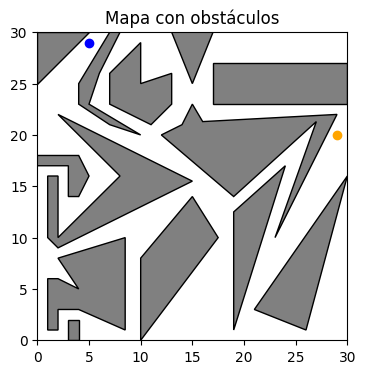

In [ ]:
# Creación de mapa para nuestras variables
plane = Map(
    initial_node=initial_node,
    end_node=end_node,
    obstacles_x=obstacles_x,
    obstacles_y=obstacles_y,
    space_limits = space_limits
)
# Mostrando mapa
plane.show(figsize = (4,4))

# 4. Búsqueda del camino de inicio a fin.

¡Sí llegamos 🥳!
Número de iteraciones: 721


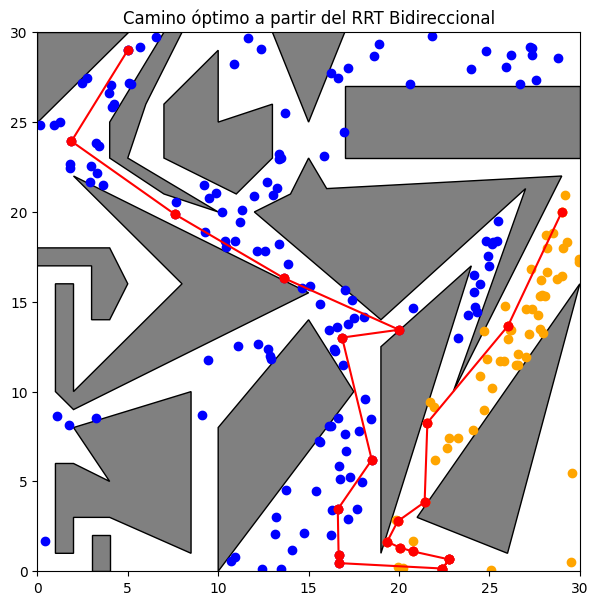

Se tardó: 1.0631158351898193 segundos ⏰


In [ ]:
# Solo invocamos la función
t = search_path(plane, search_radius = 7, show = True, verbose = True)

# 5. Conclusiones sobre este método y próximos pasos.
A comparación del RRT normalito, este tiene un performance mucho mucho mayor y estable, en su mayoría tarde menos de 1 segundo, lo cual no siempre pasaba con el RRT. Esto es un improvement bastante fuerte, pero veamos para qué valor de ```search_radius``` este tiempo se minimiza.

# 6. Encontrar el radio de búsqueda óptimo

Probaremos todos los radios de búsqueda desde el 0.5 hasta el 20 (30 veces cada uno) y sacaremos su media para comparar cuál valor del radio de búsqueda es mejor.

Para medir cuánto le falta para analizar esto importaré una librería que se llama tqdm que significa "te quiero demasiado" (no es broma) para ver las iteraciones y no desesperarme.

In [ ]:
from tqdm import tqdm

In [ ]:
# Probaremos todos los valores (al menos 30 veces cada valor)
search_radius_tests = np.arange(0.5, 20.5, 0.5)
mini_time = np.inf
best_radius = -1
iterations = 20

In [ ]:
t_means = []
for radius in tqdm(search_radius_tests):
    t_mean = 0
    for i in range(iterations):
        t_mean += search_path(plane, search_radius = radius)
    t_mean = t_mean / iterations
    t_means.append(t_mean)
    if t_mean < mini_time:
        mini_time = t_mean
        best_radius = radius

100%|██████████| 40/40 [05:58<00:00,  8.97s/it]


In [ ]:
print('El tiempo medio más corto es:', mini_time)
print('Este tiempo se logró con el radio:', best_radius)
print("Y estos son los tiempos medios en general:")
print()
for radius, t in zip(search_radius_tests, t_means):
    print("Para el radio:", radius, "Se tarda:", f"{t:.3f}")

El tiempo medio más corto es: 0.15674934387207032
Este tiempo se logró con el radio: 2.0
Y estos son los tiempos medios en general:

Para el radio: 0.5 Se tarda: 1.330
Para el radio: 1.0 Se tarda: 0.326
Para el radio: 1.5 Se tarda: 0.257
Para el radio: 2.0 Se tarda: 0.157
Para el radio: 2.5 Se tarda: 0.237
Para el radio: 3.0 Se tarda: 0.221
Para el radio: 3.5 Se tarda: 0.348
Para el radio: 4.0 Se tarda: 0.366
Para el radio: 4.5 Se tarda: 0.858
Para el radio: 5.0 Se tarda: 0.426
Para el radio: 5.5 Se tarda: 0.353
Para el radio: 6.0 Se tarda: 0.305
Para el radio: 6.5 Se tarda: 0.274
Para el radio: 7.0 Se tarda: 0.413
Para el radio: 7.5 Se tarda: 0.301
Para el radio: 8.0 Se tarda: 0.565
Para el radio: 8.5 Se tarda: 0.370
Para el radio: 9.0 Se tarda: 0.446
Para el radio: 9.5 Se tarda: 0.521
Para el radio: 10.0 Se tarda: 0.325
Para el radio: 10.5 Se tarda: 0.311
Para el radio: 11.0 Se tarda: 0.629
Para el radio: 11.5 Se tarda: 0.476
Para el radio: 12.0 Se tarda: 0.464
Para el radio: 12.5 Se

¡Sí llegamos 🥳!
Número de iteraciones: 153


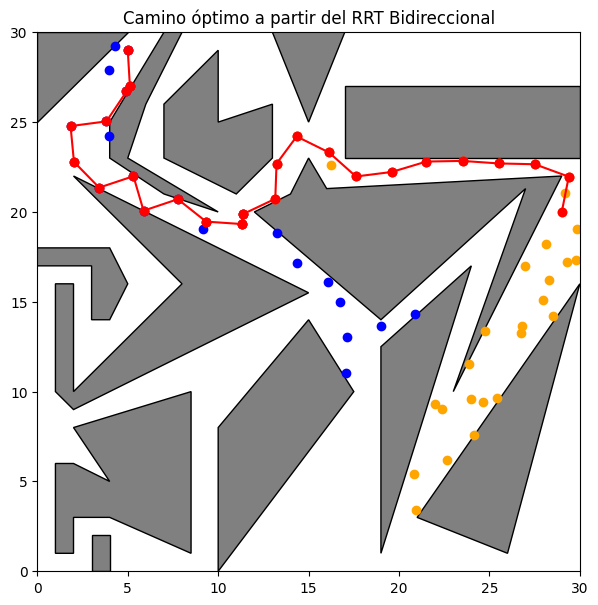

Se tardó: 0.0902705192565918 segundos ⏰


In [ ]:
# Solo invocamos la función con nuestro best radius y comprobamos
t = search_path(plane, search_radius = best_radius, verbose = True, show = True)

# 7. Conclusión final
El RRT es muy bueno para encontrar el camino desde un nodo inicial hasta un nodo final. Sin embargo, por ser un método que requiere puntos aleatorios, no es muy confiable, a pesar de que encuentra el camino debemos considerar varias cosas, la primera es que este algoritmo no te da la ruta óptima necesariamente y la segunda es que puede que se tarde demasiado. El RRT bidireccional resuelve bastante bien el problema del tiempo, sin embargo no es el camino óptimo para llegar, es decir, el que recorre menos distancia. ¡No importa en este caso! Salió y tarda en promedio **0.1282** segundos con un radio de búsqueda de **2**.

Para el caso del RRT normal en probar con 5 iteraciones (25 menos que el RRT Bidireccional) y para 20 radios diferentes (10 menos que esta) se tardó un total de 20 minutos en buscar el radio óptimo (Casi 3 veces más que esta versión), entonces definitivamente es mejor esta versión.